# Figure 4: Fruit fly brain network

We analyze the [hemibrain data set](https://www.janelia.org/project-team/flyem/hemibrain), capturing a large portion of the brain of an adult fruit fly. The data set provides the detailed layout of over 20,000 neurons and their synapses. However, we do not require access the detailed data, since for our analysis only relies on the combinatorial network describing the  existence or absence of synaptic connections between neurons and a list of the volume of neurons, both of which are provided directly by the hemibrain project.

In [1]:
import sys
sys.path.append('../cpp_extension/build/lib.linux-x86_64-3.6/')
sys.path.append('../')

import numpy as np
import igraph as ig
import pandas as pd
import itertools
from scipy.stats import gaussian_kde

#from scipy.sparse import coo_array, csr_matrix
#from scipy.sparse.linalg import eigsh

from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm

from scipy.optimize import least_squares
from scipy.linalg import eigh, inv

from skimage.draw import line, disk
import copy

import  powerlaw

plt.rcParams.update({'font.size': 20})


import matplotlib.image as mpimg

Color scheme and fonts

In [2]:
colors = [
    "#3658BF",
    "#03A678",
    "#F2B705",
    "#F24141",
    "#F28705"
]

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'CMMI10'
plt.rcParams['mathtext.rm'] = 'CMR10'

plt.rcParams.update({'font.size': 20})


### Neuron info

Read list of neurons with additional meta-data, including the volume of individual neurons.

In [3]:
neuron_info_df= pd.read_csv('../data/ff_brain/neuron_info.csv', index_col=0,dtype = {'bodyId': str})
neuron_info_df=neuron_info_df.set_index('bodyId')
neuron_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21662 entries, 200326126 to 7112579856
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pre           21662 non-null  int64  
 1   post          21662 non-null  int64  
 2   size          21662 non-null  int64  
 3   somaRadius    16782 non-null  float64
 4   somaLocation  16782 non-null  object 
 5   type          18837 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.2+ MB


### Connectome

Read combinatorial network, where nodes are neurons and links between them indicate synaptic connections. We treat the network as a weighted undirected network, where the weights are equal to the number of synapses between two neurons.

In [4]:
edges = []
ws = []
with open("../data/ff_brain/traced-total-connections.csv", 'rt') as f:
    f.readline()
    for row in f:
        v1,v2,w = row.split(',')
        edges.append((v1,v2))
        ws.append(float(w))
        
nodes = list(set([v for e in edges for v in e ]))

net = ig.Graph(directed=True)
net.add_vertices(nodes)
net.add_edges(edges)
net.es['weight']=ws

net.to_undirected(mode='collapse', combine_edges='sum')

net['name']='Fruit Fly Brain Connectome'

Add node volume

In [5]:
for v in net.vs:
    try:
        v['volume']=neuron_info_df['size'][v['name']]
    except KeyError:
        print(v['name'],'no volume available')
        pass

In [6]:
max(net.strength(weights='weight'))

225842.0

### Spectrum and leading eigenvectors

We calculate the spectra of the combinatorial Laplacian, physical Laplacian and randomized physical Laplacian using sparse linear algebra. To run the calculation, uncomment the following cells, alternatively load the pre-calculated spectra.

Construct sparse matrices

In [7]:
'''
# Combinatorial Laplacian
row=[]
col=[]
val=[]
for e in net.es:
    row.append(e.source)
    col.append(e.target)
    val.append(-e['weight'])
    
    row.append(e.target)
    col.append(e.source)
    val.append(-e['weight'])

for vid, s in enumerate(net.strength(weights='weight')):
    row.append(vid)
    col.append(vid)
    val.append(s)

Lap = coo_array((val, (row, col)), shape=(net.vcount(), net.vcount())).tocsc()
'''

"\n# Combinatorial Laplacian\nrow=[]\ncol=[]\nval=[]\nfor e in net.es:\n    row.append(e.source)\n    col.append(e.target)\n    val.append(-e['weight'])\n    \n    row.append(e.target)\n    col.append(e.source)\n    val.append(-e['weight'])\n\nfor vid, s in enumerate(net.strength(weights='weight')):\n    row.append(vid)\n    col.append(vid)\n    val.append(s)\n\nLap = coo_array((val, (row, col)), shape=(net.vcount(), net.vcount())).tocsc()\n"

In [8]:
'''
# Physical Laplacian

row=[]
col=[]
val=[]
for v in net.vs:
    row.append(v.index)
    col.append(v.index)
    val.append(v['volume'])
val = np.array(val)
val = val/np.min(val)
val = val**-.5

vs = coo_array((val, (row, col)), shape=(net.vcount(), net.vcount())).tocsc()

physLap = vs.dot(Lap.dot(vs))
'''

"\n# Physical Laplacian\n\nrow=[]\ncol=[]\nval=[]\nfor v in net.vs:\n    row.append(v.index)\n    col.append(v.index)\n    val.append(v['volume'])\nval = np.array(val)\nval = val/np.min(val)\nval = val**-.5\n\nvs = coo_array((val, (row, col)), shape=(net.vcount(), net.vcount())).tocsc()\n\nphysLap = vs.dot(Lap.dot(vs))\n"

In [9]:
'''
# Randomized physical Laplacian
row=[]
col=[]
val=[]
for v in net.vs:
    row.append(v.index)
    col.append(v.index)
    val.append(v['volume'])
val = np.array(val)
val = val/np.min(val)
val = val**-.5
np.random.shuffle(val)

rand_vs = coo_array((val, (row, col)), shape=(net.vcount(), net.vcount())).tocsc()

rand_physLap = rand_vs.dot(Lap.dot(rand_vs))
'''

"\n# Randomized physical Laplacian\nrow=[]\ncol=[]\nval=[]\nfor v in net.vs:\n    row.append(v.index)\n    col.append(v.index)\n    val.append(v['volume'])\nval = np.array(val)\nval = val/np.min(val)\nval = val**-.5\nnp.random.shuffle(val)\n\nrand_vs = coo_array((val, (row, col)), shape=(net.vcount(), net.vcount())).tocsc()\n\nrand_physLap = rand_vs.dot(Lap.dot(rand_vs))\n"

In [10]:
'''
# Combinatorial
eigs_cg = eigsh(Lap, k=net.vcount()-1, which='LM', return_eigenvectors=False)
#np.savetxt("ff_brain-eigs_cg.csv",eigs_cg)

_, vec_cg = eigsh(Lap, k=1, which='LM', return_eigenvectors=True)
with open('ff_brain_cg-leading_vec.csv', 'w') as f:
    for name, v in zip(net.vs['name'],vec_cg):
        f.write(f'{name},{v}\n')

# Physical
eigs_pcg = eigsh(physLap, k=net.vcount()-1, which='LM', return_eigenvectors=False)
np.savetxt("ff_brain-eigs_pcg.csv",eigs_pcg)

_, vec_pcg = eigsh(physLap, k=1, which='LM', return_eigenvectors=True)
with open('ff_brain_pcg-leading_vec.csv', 'w') as f:
    for name, v in zip(net.vs['name'],vec_pcg):
        f.write(f'{name},{v}\n')

# Randomized physical
eigs_rpcg = eigsh(rand_physLap, k=net.vcount()-1, which='LM', return_eigenvectors=False)
#np.savetxt("ff_brain-eigs_rpcg.csv",eigs_rpcg)
'''

'\n# Combinatorial\neigs_cg = eigsh(Lap, k=net.vcount()-1, which=\'LM\', return_eigenvectors=False)\n#np.savetxt("ff_brain-eigs_cg.csv",eigs_cg)\n\n_, vec_cg = eigsh(Lap, k=1, which=\'LM\', return_eigenvectors=True)\nwith open(\'ff_brain_cg-leading_vec.csv\', \'w\') as f:\n    for name, v in zip(net.vs[\'name\'],vec_cg):\n        f.write(f\'{name},{v}\n\')\n\n# Physical\neigs_pcg = eigsh(physLap, k=net.vcount()-1, which=\'LM\', return_eigenvectors=False)\nnp.savetxt("ff_brain-eigs_pcg.csv",eigs_pcg)\n\n_, vec_pcg = eigsh(physLap, k=1, which=\'LM\', return_eigenvectors=True)\nwith open(\'ff_brain_pcg-leading_vec.csv\', \'w\') as f:\n    for name, v in zip(net.vs[\'name\'],vec_pcg):\n        f.write(f\'{name},{v}\n\')\n\n# Randomized physical\neigs_rpcg = eigsh(rand_physLap, k=net.vcount()-1, which=\'LM\', return_eigenvectors=False)\n#np.savetxt("ff_brain-eigs_rpcg.csv",eigs_rpcg)\n'

Or load the pre-calculated spectra

In [11]:
eigs_pcg  = np.loadtxt("../data/ff_brain/ff_brain-eigs_pcg.csv")
eigs_cg   = np.loadtxt("../data/ff_brain/ff_brain-eigs_cg.csv")
eigs_rpcg = np.loadtxt("../data/ff_brain/ff_brain-eigs_rpcg.csv")

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


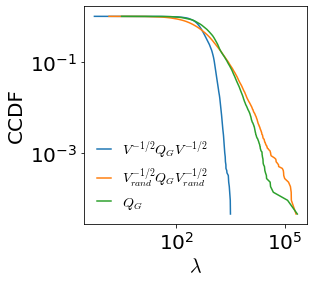

In [12]:
fig=plt.figure(figsize=(4,4))

ecdf = ECDF(eigs_pcg,side='left')
pcg_ccdf = 1-ecdf(eigs_pcg)
plt.plot(50*eigs_pcg,pcg_ccdf,label=r'$V^{-1/2}Q_{G}V^{-1/2}$')

ecdf = ECDF(eigs_rpcg,side='left')
rpcg_ccdf = 1-ecdf(eigs_rpcg)
plt.plot(50*eigs_rpcg,rpcg_ccdf,label=r'$V_{rand}^{-1/2}Q_{G}V_{rand}^{-1/2}$')

ecdf = ECDF(eigs_cg,side='left')
cg_ccdf = 1-ecdf(eigs_cg)
plt.plot(eigs_cg,cg_ccdf,label=r'$Q_{G}$')

plt.xscale('log')
plt.yscale('log')

plt.ylabel('CCDF')
plt.xlabel(r'$\lambda$')


plt.legend(handlelength=1.,fontsize=14,frameon=False);
plt.savefig('out.png',dpi=300, bbox_inches="tight");

### Strength distribution

We calculate the node strength (total number of synapses) distribution

In [13]:
ecdf = ECDF(net.strength(weights='weight'),side='left')
uss = np.unique(net.strength(weights='weight'))
ccdf  = 1-ecdf(uss)

We test various heavy tailed distributions to find the closest one to the observations

In [14]:
strs = net.strength(weights='weight')
fit = powerlaw.Fit(strs,disctretr=True)
fit.power_law.alpha

Calculating best minimal value for power law fit
/home/posfaim/anaconda3/envs/physnet/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


2.5237761899455506

In [15]:
fit.distribution_compare('power_law', 'lognormal')

(-30.648200082978963, 5.3677217426068785e-06)

In [16]:
fit.distribution_compare('truncated_power_law', 'lognormal')

(2.6915887378536745, 0.6982109101007107)

In [17]:
fit.distribution_compare('power_law', 'exponential')

/home/posfaim/anaconda3/envs/physnet/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(1231.160818585296, 4.445766080712925e-14)

In [18]:
fit.distribution_compare('lognormal', 'exponential')

(1261.809018668297, 1.6002978735965454e-15)

All heavy-tailed distributions are favored over the exponential distribution. Lognormal is favored over a power law, but we cannot differentiate between the truncated power law and lognormal distributions.

Visual inspection of alternatives:

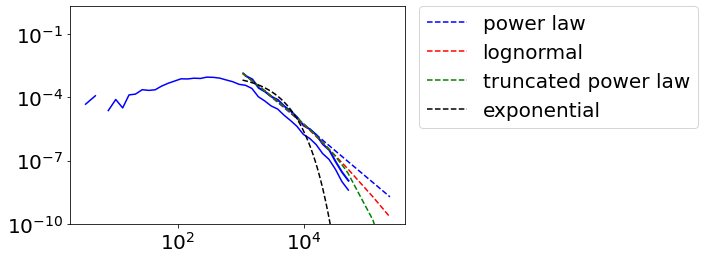

In [19]:
fig= powerlaw.plot_pdf(strs,linestyle='-',color='b')
fit.plot_pdf(color='b',linewidth=2,ax=fig)
fit.power_law.plot_pdf(color='b',linestyle='--',ax=fig,label='power law')
fit.lognormal.plot_pdf(color='r',linestyle='--',ax=fig, label='lognormal')
fit.truncated_power_law.plot_pdf(color='g',linestyle='--',ax=fig,label='truncated power law')

fit.exponential.plot_pdf(color='k',linestyle='--',ax=fig, label='exponential')
plt.ylim(bottom=1e-10)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

In [20]:
fit.truncated_power_law.alpha, fit.truncated_power_law.xmin,fit.truncated_power_law.xmax

(2.3165810484416016, 1058.0, None)

Text(0, 0.5, 'CCDF')

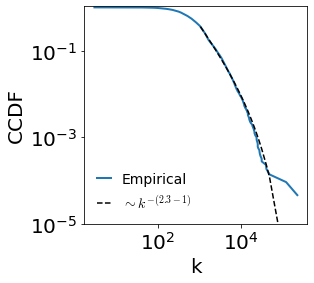

In [21]:
fig=plt.figure(figsize=(4,4))

plt.plot(uss,ccdf,'-',linewidth=2,label='Empirical')

ss= np.array([400.,1e5])
#plt.plot(ss,np.exp(intercept)*ss**-(fit.power_law.alpha-1),'k--',)
fit_s_min = fit.truncated_power_law.xmin
norm = ccdf[np.where(uss==fit_s_min)[0]]
plt.plot(uss[uss>=fit_s_min],
         fit.truncated_power_law.ccdf(uss[uss>=fit_s_min])*norm,
         'k--', label=r'$\sim k^{-(%.1f-1)}$'%fit.truncated_power_law.alpha)

plt.ylim(bottom=1e-5)

plt.xscale('log')
plt.yscale('log')
plt.legend(handlelength=1.,fontsize=14,loc='lower left',frameon=False)
plt.xlabel('k')
plt.ylabel('CCDF')
#plt.xlim(right=1e5)

### Strength-volume

Fit
$$k=c\cdot v^\alpha$$
to characterize the node strength-volume correlation.

In [22]:
vols = np.array(net.vs['volume'])
strs = np.array(net.strength(weights='weight'))
res2 = least_squares(lambda a: a[1]*vols**a[0]-strs, x0=(1.,1.))
res2

 active_mask: array([0., 0.])
        cost: 41583441739.49872
         fun: array([  78.59703158,  306.7754545 , -235.14315598, ...,  378.64159547,
       -666.73673548,  -67.87018048])
        grad: array([-1.13500827e+06, -4.12304367e+10])
         jac: array([[4.89385391e+03, 5.14637625e+08],
       [1.79924891e+04, 1.78177563e+09],
       [1.23779505e+04, 1.24667601e+09],
       ...,
       [9.24214796e+04, 8.52579848e+09],
       [1.51624523e+04, 1.51312976e+09],
       [2.25920381e+04, 2.21465181e+09]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 63
        njev: 52
  optimality: 41230436725.84497
      status: 2
     success: True
           x: array([1.06403887e+00, 5.04426841e-07])

Calculate the kernel density estimate for visualization

In [23]:
values = np.log(np.array([net.vs['volume'],net.strength(weights='weight')]))
kernel = gaussian_kde(values)

xmin = values[0].min()
xmax = values[0].max()
ymin = values[1].min()
ymax = values[1].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

f = np.reshape(kernel(positions).T, xx.shape)

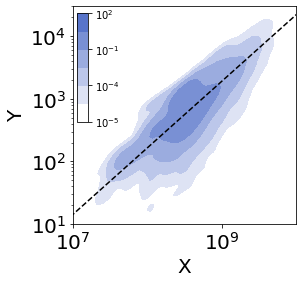

In [24]:
fig = plt.figure(figsize=(4,4))
ax = fig.gca()

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', ["#FFFFFF",colors[0]], 7)
color_scale=sorted(list(set([cmap(a) for a in np.linspace(0,1.,1000)])),reverse=True)


pdf = f/xx/yy
levels = np.logspace(-5, -2, 7 )
cfset = ax.contourf(np.exp(xx), np.exp(yy), pdf, levels=levels,
                    colors=color_scale[:],alpha=1.)

xs=np.logspace(5,11)

plt.plot(xs,res2.x[1]*xs**res2.x[0],'--k', label=r'$k \sim v^{%.2f}$'%res2.x[0],lw=1.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.xlim(left=1e7,right=1e10)
plt.ylim(bottom=10,top=3e4)


cbar=plt.colorbar(cfset,format=r"$10^{%g}$",shrink=1.,
                  cax=ax.inset_axes((0.02, 0.47, 0.05, 0.5)),
                 ticks=[1e-5, 1e-4,1e-3,.01])
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_yticklabels([r'$\mathregular{10^{-5}}$',r'$\mathregular{10^{-4}}$',
                         r'$\mathregular{10^{-1}}$',r'$\mathregular{10^2}$'])
plt.xscale('log')
plt.yscale('log')

### Leading eigenvectors

Load leading eigenvector of the combinatorial Laplacian

In [25]:
vec_cg_D = {}
with open('../data/ff_brain/ff_brain_cg-leading_vec.csv') as fn:
    for row in fn:
        name, v = row.split(',')
        vec_cg_D[name] = float(v)

vec_cg = np.array([vec_cg_D[name] for name in net.vs['name']])

Load leading eigenvector of the physical Laplacian

In [26]:
vec_pcg_D = {}
with open('../data/ff_brain/ff_brain_pcg-leading_vec.csv') as fn:
    for row in fn:
        name, v = row.split(',')
        vec_pcg_D[name] = float(v)

vec_pcg = np.array([vec_pcg_D[name] for name in net.vs['name']])

Identify the nodes that the eigenvectors concentrate on, we refer to these nodes as hubs

In [27]:
pcg_hub = np.abs(vec_pcg).argmax()
cg_hub  = np.abs(vec_cg).argmax()
pcg_hub, cg_hub

(8711, 10049)

Calculate the rank of the hubs based on degree and volume

In [28]:
(np.array(net.strength(weights='weight'))>net.strength(weights='weight')[cg_hub]).sum()

0

In [29]:
(np.array(net.vs['volume'])>net.vs['volume'][cg_hub]).sum()

1

The hub in combinatorial network has the highest degree and second highest volume

In [30]:
(np.array(net.strength(weights='weight'))>net.strength(weights='weight')[pcg_hub]).sum()

158

In [31]:
(np.array(net.vs['volume'])>net.vs['volume'][pcg_hub]).mean()

0.14823192687655803

In [32]:
ratio = np.array(net.strength(weights='weight'))/np.array(net.vs['volume'])

In [33]:
(ratio>ratio[pcg_hub]).sum()

0

While the hub in the physical network has the highest degree to volume ratio.

To visualize the network, we generate a layout based on the combinatorial network. Uncomment the code below to generate a fresh layout, or load the pre-calculated coordinates.

In [34]:
'''
layout = net.layout_lgl()
layout.fit_into((5000,5000))
coords = np.array(layout.coords)
'''

'\nlayout = net.layout_lgl()\nlayout.fit_into((5000,5000))\ncoords = np.array(layout.coords)\n'

In [35]:
coords_D = {}
with open('../data/ff_brain/ff_brain_layout.csv') as fn:
    for row in fn:
        name, v0, v1 = row.split(',')
        coords_D[name] = [float(v0),float(v1)]

coords = np.array([coords_D[name] for name in net.vs['name']])

There are many links, draw them as a rasterized image.

We create a monochrome square image with `side`x`side` pixels, and draw each link with weight >10 as a straight line. The intensity of each pixel is proportional to the number of links passing through.

In [36]:
side = 5000
img_links = np.zeros((side,side))
coords_int = np.array(coords, dtype=int)-1
for e in net.es:
    if e['weight']>10:
        y1, x1 = coords_int[e.source]
        y2, x2 = coords_int[e.target]
        rr, cc = line(x1, y1, x2, y2)
        img_links[rr,cc] += 1
    
img_links *= 255/img_links.max()


Putting together the visualization of the leading eigenvectors:
* The pixel intensity of the link image is transformed for better visuals
* Color of each node `i` indicates the absolute value of the eigenvector at node `i` on a logarithmic color scale
* Node size is a linear function of the node weighted degree

Note that the figure in the publication includes a zoomed in inset for the leading eigenvector of the physical Laplacian which was created manually and is not reproduced here.

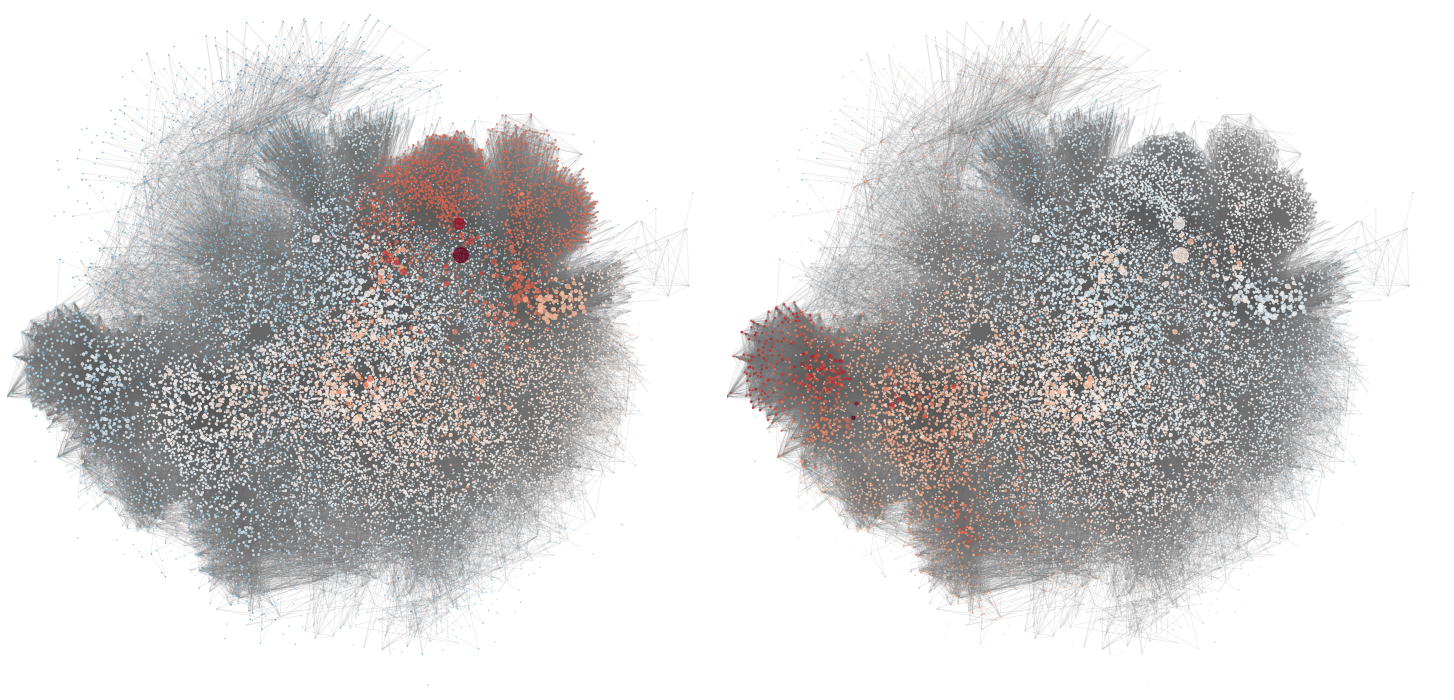

In [37]:
fig, axs = plt.subplots(1,2,figsize=(20,10))


img2 = 255-np.exp(-img_links**.1/100)

sizes = np.array([.1 + 1.e-3*k for k in net.strength(weights='weight')])
indices = sizes.argsort() # node plotting order


plt.sca(axs[0])

# color scale
norm = LogNorm(vmin=min(np.abs(vec_cg).min(),np.abs(vec_pcg).min()), vmax=max(np.abs(vec_cg).max(),np.abs(vec_pcg).max()))

plt.imshow(img2,cmap='binary')
plt.scatter(coords[:,0][indices],
            coords[:,1][indices],
            c=np.abs(vec_cg)[indices],
            s=sizes[indices],
            cmap='RdBu_r',norm=norm, alpha=.75)
plt.axis('off')


plt.sca(axs[1])


plt.imshow(img2,cmap='binary')
plt.scatter(coords[:,0][indices],
            coords[:,1][indices],
            c=np.abs(vec_pcg)[indices],
            s=sizes[indices],
            cmap='RdBu_r',norm=norm, alpha=.75)
plt.axis('off')




axs[0].set_position((0.0, 0., .5,1))
axs[1].set_position((0.5, 0., .5,1))


#fig.set_dpi(100)
#fig.savefig('ff_brain-layout-vec-wo_inset.png', pad_inches=0)

### Decay of the eigenvector

Calculate geodesic distances from hubs

In [38]:
pcg_dist = np.array(net.shortest_paths(source=pcg_hub))[0]
cg_dist  = np.array(net.shortest_paths(source=cg_hub))[0]

In [39]:
mean_pcg_vec = []
stddev_pcg_vec = []
count_pcg_vec = []
for d in range(6):
    if (pcg_dist==d).sum() !=0:
        mean_pcg_vec.append( np.abs(vec_pcg[pcg_dist==d]).mean())
        stddev_pcg_vec.append( np.abs(vec_pcg[pcg_dist==d]).std())
        count_pcg_vec.append( len(vec_pcg[pcg_dist==d]))
        
mean_pcg_vec = np.array(mean_pcg_vec)
stddev_pcg_vec = np.array(stddev_pcg_vec)
count_pcg_vec = np.array(count_pcg_vec)
   
    
mean_cg_vec = []
stddev_cg_vec = []
count_cg_vec = []
for d in range(6):
    if (cg_dist==d).sum() !=0:
        mean_cg_vec.append( np.abs(vec_cg[cg_dist==d]).mean())
        stddev_cg_vec.append(np.abs(vec_cg[cg_dist==d]).std())
        count_cg_vec.append( len(vec_cg[cg_dist==d]))

mean_cg_vec = np.array(mean_cg_vec)
stddev_cg_vec = np.array(stddev_cg_vec)
count_cg_vec = np.array(count_cg_vec)

## Final figure

Text(1.75, 0.1, '$Q_\\mathrm{phys}$')

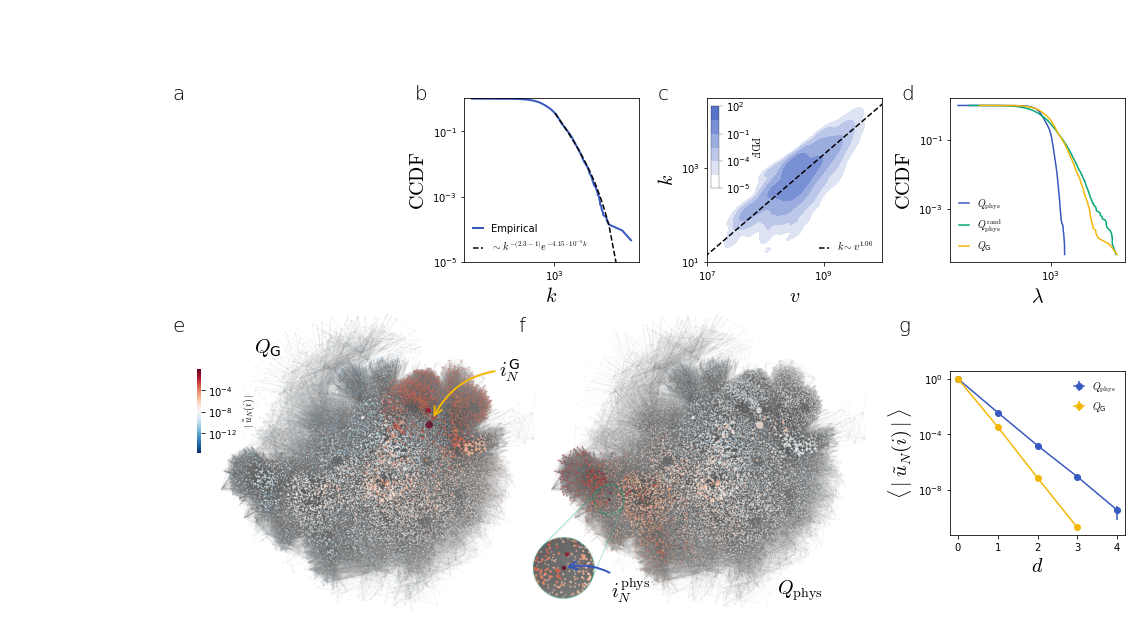

In [40]:
fig, ax = plt.subplots(2,4,figsize=(4*(3+3/8),2.5*(3+3/8)))

#layout

plt.sca(ax[0,0])
plt.axis('off')


##strength CCDF

plt.sca(ax[0,1])

plt.plot(uss,ccdf,'-',linewidth=2,label='Empirical',color=colors[0])

fit_s_min = fit.truncated_power_law.xmin
norm = ccdf[np.where(uss==fit_s_min)[0]]
plt.plot(uss[uss>=fit_s_min],
         fit.truncated_power_law.ccdf(uss[uss>=fit_s_min])*norm,
         'k--', label=rf'$\sim k^{{-({fit.truncated_power_law.alpha:.1f}-1)}}e^{{-4.15\cdot 10^{{-5}}k}}$')
plt.ylim(bottom=1e-5)

plt.xscale('log')
plt.yscale('log')
plt.legend(handlelength=1.,fontsize=10,loc='lower left',frameon=False)
plt.xlabel(r'$k$')
plt.ylabel(r'$\mathrm{CCDF}$')


##vol-strength

plt.sca(ax[0,2])


cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', ["#FFFFFF",colors[0]], 7)
color_scale=sorted(list(set([cmap(a) for a in np.linspace(0,1.,1000)])),reverse=True)


pdf = f/xx/yy
levels = np.logspace(-5, -2, 7 )
cfset = ax[0,2].contourf(np.exp(xx), np.exp(yy), pdf, levels=levels,
                    colors=color_scale[:],alpha=1.)
xs=np.logspace(5,11)
plt.plot(xs,res2.x[1]*xs**res2.x[0],'--k', label=r'$k \sim v^{%.2f}$'%res2.x[0],lw=1.5)

plt.xlim(left=1e7,right=1e10)
plt.ylim(bottom=10,top=3e4)


cbar=plt.colorbar(cfset,format=r"$10^{%g}$",shrink=1.,
                  cax=ax[0,2].inset_axes((0.02, 0.45, 0.05, 0.5)),
                 ticks=[1e-5, 1e-4,1e-3,.01])
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_yticklabels([r'$\mathregular{10^{-5}}$',r'$\mathregular{10^{-4}}$',
                         r'$\mathregular{10^{-1}}$',r'$\mathregular{10^2}$'])
cbar.outline.set_linewidth(.25)
cbar.ax.tick_params(width=.25)
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel(r'$\mathrm{PDF}$',size=10, rotation=270)


plt.xscale('log')
plt.yscale('log')

plt.legend(handlelength=1.,loc="lower right",fontsize=10,frameon=False);
plt.xlabel(r'$v$')
plt.ylabel(r'$k$') 


##lambda CCDF

plt.sca(ax[0,3])

ecdf = ECDF(eigs_pcg,side='left')
pcg_ccdf = 1-ecdf(eigs_pcg)
plt.plot(50*eigs_pcg,pcg_ccdf,label=r'$Q_\mathrm{phys}$',color=colors[0])

ecdf = ECDF(eigs_rpcg,side='left')
rpcg_ccdf = 1-ecdf(eigs_rpcg)
plt.plot(50*eigs_rpcg,rpcg_ccdf,label=r'$Q_\mathrm{phys}^\mathrm{rand}$',color=colors[1])

ecdf = ECDF(eigs_cg,side='left')
cg_ccdf = 1-ecdf(eigs_cg)
plt.plot(eigs_cg,cg_ccdf,label=r'$Q_\mathcal{G}$',color=colors[2])


plt.xscale('log')
plt.yscale('log')

plt.ylabel(r'$\mathrm{CCDF}$')
plt.xlabel(r'$\lambda$')

plt.legend(handlelength=1.,fontsize=10,frameon=False);

plt.sca(ax[1,0])

img = mpimg.imread('ff_brain-layout-vec-inset.png')
imgplot = plt.imshow(img)



plt.axis('off')

plt.sca(ax[1,1])

plt.axis('off')



plt.sca(ax[1][2])
plt.axis('off')


plt.sca(ax[1,3])

plt.errorbar(np.arange(len(mean_pcg_vec)), mean_pcg_vec, 1.96*stddev_pcg_vec/count_pcg_vec**.5, None, '-o',color=colors[0],label=r'$Q_\mathrm{phys}$')
plt.errorbar(np.arange(len(mean_cg_vec)),mean_cg_vec,1.96*stddev_cg_vec/count_cg_vec**.5, None, '-o',color=colors[2],label=r'$Q_\mathcal{G}$')

plt.yscale('log')

plt.ylabel(r'$\langle\mid \tilde{u}_N(i)\mid\rangle$')
plt.xlabel(r'$d$')
plt.xticks([0,1,2,3,4])
plt.legend(handlelength=1.,fontsize=10,frameon=False);

#===========================


plt.text(-0.28, 1.08,'a', ha='left', va='top', transform = ax[0,0].transAxes,weight='light')
plt.text(-0.28, 1.08,'b', ha='left', va='top', transform = ax[0,1].transAxes,weight='light')
plt.text(-0.28, 1.08,'c', ha='left', va='top', transform = ax[0,2].transAxes,weight='light')
plt.text(-0.28, 1.08,'d', ha='left', va='top', transform = ax[0,3].transAxes,weight='light')
plt.text(-0.073, .96,'e', ha='left', va='top', transform = ax[1,0].transAxes,weight='light')
plt.text( 0.5-.05, .96,'f', ha='left', va='top', transform = ax[1,0].transAxes,weight='light')
plt.text(1.025, .96,'g', ha='left', va='top', transform = ax[1,0].transAxes,weight='light')


#fig.tight_layout()

lm =.05
bm =.1/(5/4)
rm =.025/(5/4)+lm
tm =.05+bm


ax[0,0].set_position((0.0+lm, 0.6+bm,.25-rm,.4-tm))
ax[0,1].set_position((0.25+lm,0.6+bm,.25-rm,.4-tm))
ax[0,2].set_position((0.5+lm, 0.6+bm, .25-rm,.4-tm))
ax[0,3].set_position((0.75+lm,0.6+bm ,.25-rm,.4-tm))

ax[1,0].set_position((0.0+lm,  -0.01,.75-rm,.7))
ax[1,2].set_position((0., 0.6 ,.2,.5))
ax[1,3].set_position((0.75+lm, 0.15+bm, .25-rm,.4-tm))


for a in ax.reshape(-1):
    plt.sca(a)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)


ax_cb = fig.add_axes([-0.17,0.32,.23,.23])
plt.sca(ax_cb)
plt.axis('off')

norm = LogNorm(vmin=min(np.abs(vec_cg).min(),np.abs(vec_pcg).min()), vmax=max(np.abs(vec_cg).max(),np.abs(vec_pcg).max()))
cmap=matplotlib.cm.ScalarMappable(norm=norm, cmap='RdBu_r')

cb = fig.colorbar(cmap, ax=ax_cb,shrink=0.6, orientation='vertical')
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=10)
cb.set_label(r'$\mid \tilde{u}_N(i)\mid$',fontsize=10)

plt.sca(ax[1,0])

plt.annotate(r"$i^\mathcal{G}_N$", (0.32,0.65),
                  xytext=(0.42, .78),
                  arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.3",lw=2,color=colors[2]),
                 xycoords=ax[1,0].transAxes
                 )


plt.annotate(r"$i^\mathrm{phys}_N$", (0.52,0.2),
                  xytext=(0.59, .11),
                  arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.3",lw=2.,color=colors[0]),
                 xycoords=ax[1,0].transAxes
                 )

plt.text(0.05, .9,r'$Q_\mathcal{G}$', ha='left', va='top', transform = ax[1,0].transAxes)
plt.text(1.75, .1,r'$Q_\mathrm{phys}$', ha='left', va='top', transform = ax[1,1].transAxes)


#plt.savefig('out.pdf', dpi = 300)